In [1]:
import sys
import os
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath('../..'))

from offshore_wind_nj.config import JERSEY_ATLANTIC_DATA_DIR, FIGURES_DIR
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2025-04-01 21:24:53.194 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research


# Load the dataset

In [2]:
jersy_atlantic_path = JERSEY_ATLANTIC_DATA_DIR / 'JAW_Wind_Data.xlsx'
df = pd.read_excel(jersy_atlantic_path)

# Data Cleaning

In [3]:
df['u_vector'] = np.sin(np.radians(df['WindDirection']))
df['v_vector'] = np.cos(np.radians(df['WindDirection']))

In [4]:
df.fillna({'PowerkW':-10}, inplace=True)

In [9]:
df.loc[df[df['PowerkW']<=0].index, 'PowerkW'] = 0

In [10]:
# Identify timestamps where ALL turbines have missing WindSpeed data
timestamps_all_missing = df.groupby('StampTime')['WindSpeed'].apply(lambda x: x.isna().all())

# Get a list of these timestamps
timestamps_to_drop = timestamps_all_missing[timestamps_all_missing].index

# Drop rows with these timestamps
df = df[~df['StampTime'].isin(timestamps_to_drop)].reset_index(drop=True)


In [11]:
df[df['StampTime'].isin(timestamps_all_missing[timestamps_all_missing].index)]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,u_vector,v_vector


In [12]:
for column in ['WindSpeed', 'u_vector', 'v_vector']:
    df[column] = df.groupby('StampTime')[column]\
                                    .transform(lambda x: x.fillna(x.mean()))

In [13]:
# Compute wind direction from u and v components
def compute_wind_direction(u, v):
    wind_direction = (np.degrees(np.arctan2(u, v)) + 360) % 360
    return wind_direction

# Example usage:
df['WindDirection'] = compute_wind_direction(df['u_vector'], df['v_vector'])

In [14]:
df["WindSpeed_Squared"] = df["WindSpeed"] ** 2
df["WindSpeed_Cubic"] = df["WindSpeed"] ** 3

In [15]:
df['u_vector_cubic'] = np.sin(np.radians(df['WindDirection'])) * df['WindSpeed_Cubic']
df['v_vector_cubic'] = np.cos(np.radians(df['WindDirection'])) * df['WindSpeed_Cubic']

# Turbines coordinates

In [16]:
turbines = [
    {"Turbine": "T01", "latitude": 39.3839, "longitude": -74.4485},
    {"Turbine": "T02", "latitude": 39.3822, "longitude": -74.4504},
    {"Turbine": "T03", "latitude": 39.3801, "longitude": -74.4497},
    {"Turbine": "T04", "latitude": 39.3825, "longitude": -74.4454},
    {"Turbine": "T05", "latitude": 39.3811, "longitude": -74.4477}
]

turbines_df = pd.DataFrame(turbines)


In [17]:
df = pd.merge(df, turbines_df, on='Turbine', how='left')


# GNN Tuturial AAAI 2025

## 📡 Graph Neural Network for Wind Farm Energy Modeling

We model the wind farm as a graph where:

- **Nodes** represent individual wind turbines.
- **Edges** represent potential influence between turbines (e.g., due to wake effects).
- **Node features** describe each turbine's state at a given timestamp, including wind conditions and location.
- **Target labels** are the actual energy output (`PowerkW`) produced by each turbine.

---

### 🔢 Node Feature Vector

Each turbine $i$ is represented by a feature vector:

$$
\mathbf{x}_i = [u_i, v_i, \text{lat}_i, \text{lon}_i]
$$

Where:

- $u_i$, $v_i$ are wind vector components (cubic-adjusted)
- $\text{lat}_i$, $\text{lon}_i$ are standardized spatial coordinates

---

### 🎯 Prediction Objective

We want to predict the energy output $y_i$ for each turbine $i$ using a GNN that learns from both:

- The turbine's own features $\mathbf{x}_i$
- The wind-structured relationships to other turbines in the graph

The prediction is:

$$
\hat{y}_i = \Phi(\mathbf{x}_i; \mathcal{G})
$$

Where:

- $\Phi$ is the GNN function
- $\mathcal{G}$ is the graph constructed using turbine layout and wind direction

---

### 🔗 Graph Structure

Edges $\mathcal{E}$ in the graph are defined by:

- **Proximity**: Turbines close to each other are more likely to interact
- **Wind Directionality**: Edges are directed from upstream to downstream turbines
- **Wake Likelihood**: Optional edge weights can model wake strength based on wind alignment

---

### 🧠 Learning Task

We train the GNN using supervised learning with Mean Squared Error (MSE) loss:

$$
\mathcal{L}(y, \hat{y}) = \frac{1}{2} \sum_i (y_i - \hat{y}_i)^2
$$

The GNN learns how wind patterns correlate across turbines and how they affect energy production over time.


# 📘 Static Graph GNN Training Log (Wake-Aware)

## ✅ Objective
Develop a Graph Neural Network (GNN) model that captures directional relationships among wind turbines to understand and predict wake effects, using historical wind direction and energy output data.

---

## 🧭 Step-by-Step Summary

### 1. **Understand the Data Structure**
- Each row represents a turbine's measurements at a specific timestamp.
- Key columns:
  - `u_vector_cubic`, `v_vector_cubic` (wind vectors)
  - `latitude`, `longitude` (location)
  - `WindDirection` (azimuth in degrees FROM which wind is coming)
  - `PowerkW` (energy output, our prediction target)

---

### 2. **Define Graph Logic**
- Each turbine = 1 **node** in a graph.
- Each timestamp = 1 **graph**.
- Edge creation logic:
  - For each turbine `i`, compute **wind flow direction**: `(WindDirection_i + 180) % 360`
  - For each other turbine `j`, compute **angle from `i → j`**
  - If the angular difference is within a **45° threshold**, create edge `i → j` (indicating wake influence)

---

### 3. **Feature Preprocessing**
For each timestamp:
- Standardize: `u_vector_cubic`, `v_vector_cubic`, `latitude`, `longitude`
- Normalize: `PowerkW` using MinMaxScaler

---

### 4. **Graph Construction**
- For each timestamp, build a `torch_geometric.data.Data` object:
  - `x`: node features = `[u, v, lat, lon]`
  - `edge_index`: dynamically computed using wind-aligned edge logic
  - `y`: labels = normalized `PowerkW`
- Append each graph to a list (`graph_list`) for training

---

### 5. **GNN Architecture**
```python
class TurbineGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(TurbineGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x
```

---

### 6. **Training Setup**
- Device: GPU if available
- Optimizer: Adam
- Loss: MSE between predicted and actual `PowerkW`
- Trained for 100 epochs with logging every 10 epochs

---

### ✅ Next Steps
- Evaluate predictions on **unseen timestamps**
- Visualize **node embeddings** and compare directional influence
- Analyze **wake effects** under varying wind conditions

---

### 🧠 Key Takeaway
By modeling turbine wake effects using directed graphs informed by real wind direction data, we can train a GNN that learns to predict energy output in a physically meaningful way.

---

*End of training log.*



In [18]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt

def compute_angle_between_turbines(lat1, lon1, lat2, lon2):
    delta_x = lon2 - lon1
    delta_y = lat2 - lat1
    angle_rad = np.arctan2(delta_x, delta_y)
    angle_deg = np.degrees(angle_rad) % 360
    return angle_deg

def create_directional_graph(filtered_df):
    edge_index = []
    node_features = []
    turbine_ids = filtered_df['Turbine'].tolist()
    num_turbines = len(turbine_ids)

    # ✅ Use original wind azimuth values (in degrees)
    wind_azimuths = filtered_df['WindDirection'].values

    # 🧠 Prepare node features (exclude PowerkW from input)
    for _, row in filtered_df.iterrows():
        node_features.append([
            row['u_vector_cubic'], row['v_vector_cubic'],
            row['latitude'], row['longitude']
        ])

    azimuth_threshold = 60  # degrees

    # 🌬️ Create directional edges based on wind flow alignment
    for i in range(num_turbines):
        lat_i, lon_i = filtered_df.iloc[i][['latitude', 'longitude']]
        azimuth_i = wind_azimuths[i]
        flow_direction_i = (azimuth_i + 180) % 360  # Wind is blowing toward this angle

        for j in range(num_turbines):
            if i == j:
                continue
            lat_j, lon_j = filtered_df.iloc[j][['latitude', 'longitude']]
            angle_ij = compute_angle_between_turbines(lat_i, lon_i, lat_j, lon_j)

            delta = abs(angle_ij - flow_direction_i)
            delta = min(delta, 360 - delta)  # Handle circular angle wrap-around

            if delta <= azimuth_threshold:
                edge_index.append([i, j])

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor(filtered_df['PowerkW'].values, dtype=torch.float)

    graph_data = Data(x=x, edge_index=edge_index, y=y)
    return graph_data, turbine_ids


# 📋 Print the graph edges for inspection
def print_graph_edges(graph_data, turbine_ids):
    print("\nGraph Edges (Directed):")
    for src, dst in graph_data.edge_index.t().tolist():
        print(f"{turbine_ids[src]} → {turbine_ids[dst]}")


# 📍 Visualize turbine layout with directional arrows
def plot_graph_with_arrows(filtered_df, graph_data, turbine_ids):
    plt.figure(figsize=(8, 6))

    # Plot turbine positions
    for i, row in filtered_df.iterrows():
        plt.scatter(row['longitude'], row['latitude'], color='blue', s=100, zorder=3)
        plt.text(row['longitude'] + 0.0005, row['latitude'] + 0.0005, row['Turbine'], fontsize=10)

    # Plot arrows (edges)
    for src, dst in graph_data.edge_index.t().tolist():
        x_start = filtered_df.iloc[src]['longitude']
        y_start = filtered_df.iloc[src]['latitude']
        x_end = filtered_df.iloc[dst]['longitude']
        y_end = filtered_df.iloc[dst]['latitude']
        plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start,
                  head_width=0.0003, head_length=0.0003, fc='gray', ec='gray', alpha=0.7, length_includes_head=True)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Wind-Informed Directional Graph of Turbines")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Loop through all timestamps and create one directional graph per timestamp

In [19]:
filtered_df = df.copy()

# Standardize wind vectors
scaler_vectors = StandardScaler()
filtered_df[['u_vector_cubic', 'v_vector_cubic']] = scaler_vectors.fit_transform(
    filtered_df[['u_vector_cubic', 'v_vector_cubic']]
)

# Standardize coordinates
scaler_coords = StandardScaler()
filtered_df[['latitude', 'longitude']] = scaler_coords.fit_transform(
    filtered_df[['latitude', 'longitude']]
)

# Normalize power output
scaler_power = MinMaxScaler()
filtered_df['PowerkW'] = scaler_power.fit_transform(
    filtered_df[['PowerkW']]
)


    



In [25]:
from torch_geometric.loader import DataLoader

# 1. Shuffle timestamps consistently (important for time generalization)
from sklearn.model_selection import train_test_split

# Shuffle the timestamp list consistently (based on your full df)
unique_timestamps = sorted(df['StampTime'].unique())
train_stamps, test_stamps = train_test_split(unique_timestamps, test_size=0.2, shuffle=True, random_state=42)

# 2. Split the graphs based on the timestamp keys
train_graphs = []
test_graphs = []

for timestamp in train_stamps:
    gdf = filtered_df[filtered_df['StampTime'] == timestamp]
    graph_data, _ = create_directional_graph(gdf)
    if graph_data.edge_index.numel() > 0 and graph_data.edge_index.dim() == 2:
        train_graphs.append(graph_data)

for timestamp in test_stamps:
    gdf = filtered_df[filtered_df['StampTime'] == timestamp]
    graph_data, _ = create_directional_graph(gdf)
    if graph_data.edge_index.numel() > 0 and graph_data.edge_index.dim() == 2:
        test_graphs.append(graph_data)

# 3. Set up PyG DataLoaders
train_loader = DataLoader(train_graphs, batch_size=8, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=8, shuffle=False)

print(f"Training graphs: {len(train_graphs)}, Testing graphs: {len(test_graphs)}")


Training graphs: 34639, Testing graphs: 8661


In [31]:
train_graphs

[Data(x=[5, 4], edge_index=[2, 6], y=[5]),
 Data(x=[5, 4], edge_index=[2, 5], y=[5]),
 Data(x=[5, 4], edge_index=[2, 1], y=[5]),
 Data(x=[5, 4], edge_index=[2, 7], y=[5]),
 Data(x=[5, 4], edge_index=[2, 12], y=[5]),
 Data(x=[5, 4], edge_index=[2, 7], y=[5]),
 Data(x=[5, 4], edge_index=[2, 5], y=[5]),
 Data(x=[5, 4], edge_index=[2, 7], y=[5]),
 Data(x=[5, 4], edge_index=[2, 12], y=[5]),
 Data(x=[5, 4], edge_index=[2, 6], y=[5]),
 Data(x=[5, 4], edge_index=[2, 8], y=[5]),
 Data(x=[5, 4], edge_index=[2, 5], y=[5]),
 Data(x=[5, 4], edge_index=[2, 12], y=[5]),
 Data(x=[5, 4], edge_index=[2, 12], y=[5]),
 Data(x=[5, 4], edge_index=[2, 3], y=[5]),
 Data(x=[5, 4], edge_index=[2, 8], y=[5]),
 Data(x=[5, 4], edge_index=[2, 9], y=[5]),
 Data(x=[5, 4], edge_index=[2, 11], y=[5]),
 Data(x=[5, 4], edge_index=[2, 9], y=[5]),
 Data(x=[5, 4], edge_index=[2, 9], y=[5]),
 Data(x=[5, 4], edge_index=[2, 12], y=[5]),
 Data(x=[5, 4], edge_index=[2, 4], y=[5]),
 Data(x=[5, 4], edge_index=[2, 4], y=[5]),
 Data

# Define the GNN model

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Updated GNN model with dropout
class TurbineGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(TurbineGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, data, return_embedding=False):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        if return_embedding:
            return x  # 💡 Return embedding before final output
        x = self.conv2(x, edge_index)
        return x

# Set dimensions and device
input_dim = 4   # u, v, lat, lon
hidden_dim = 64
output_dim = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
model = TurbineGNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 🌀 Learning rate scheduler: decays LR every 30 epochs by factor 0.5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Load your pre-built list of graphs
loader = train_loader

# 🚀 Train the model
model.train()
for epoch in range(1, 101):
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        target = batch.y.unsqueeze(1)
        loss = nn.functional.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()  # 📉 Adjust LR

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(loader):.4f}")


Epoch 10, Loss: 0.0478
Epoch 20, Loss: 0.0503
Epoch 30, Loss: 0.0552
Epoch 40, Loss: 0.0532
Epoch 50, Loss: 0.0531
Epoch 60, Loss: 0.0532
Epoch 70, Loss: 0.0517
Epoch 80, Loss: 0.0523
Epoch 90, Loss: 0.0525
Epoch 100, Loss: 0.0520


/tmp/ipykernel_101796/2842044210.py:30: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


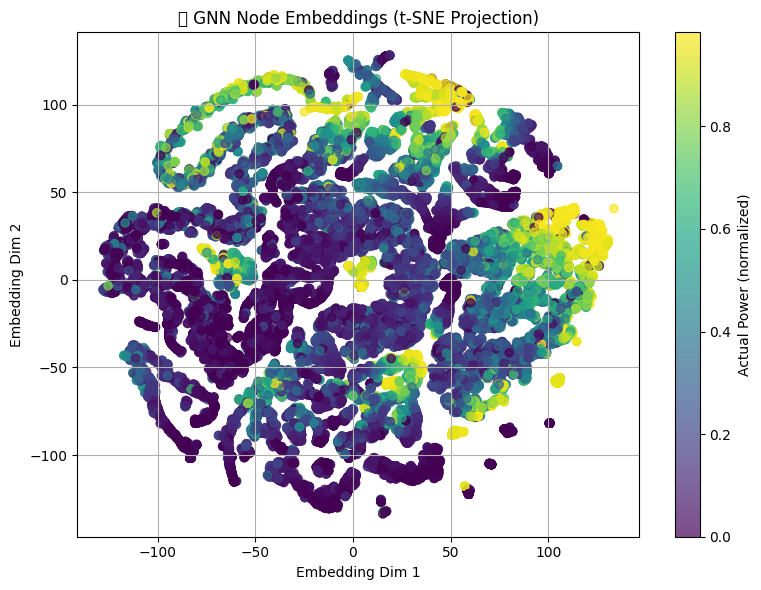

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Collect embeddings from test set
embeddings = []
labels = []  # Optional: turbine index or actual power

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        node_embed = model(batch, return_embedding=True)
        embeddings.append(node_embed.cpu().numpy())
        labels.extend(batch.y.cpu().numpy())  # or use turbine index

embeddings = np.vstack(embeddings)

# 2. Reduce dimensionality (use t-SNE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# 3. Plot the embeddings
plt.figure(figsize=(8, 6))
sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Actual Power (normalized)')
plt.title("🧠 GNN Node Embeddings (t-SNE Projection)")
plt.xlabel("Embedding Dim 1")
plt.ylabel("Embedding Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()



/tmp/ipykernel_101796/1355061531.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


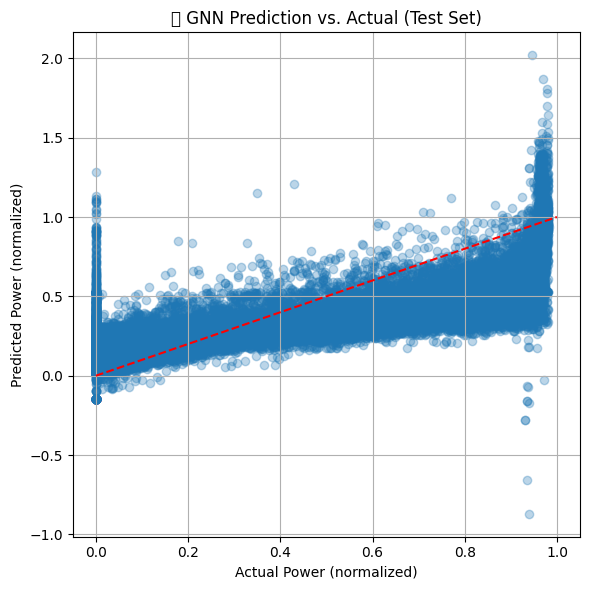

In [29]:
import matplotlib.pyplot as plt

# 1. Collect predictions and targets
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = model(batch)
        all_preds.append(output.cpu().numpy())
        all_targets.append(batch.y.unsqueeze(1).cpu().numpy())

# 2. Concatenate all predictions/targets
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# 3. Plot
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.3)
plt.plot([0, 1], [0, 1], 'r--')  # Ideal 1:1 line
plt.xlabel("Actual Power (normalized)")
plt.ylabel("Predicted Power (normalized)")
plt.title("🔍 GNN Prediction vs. Actual (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_101796/629810017.py:33: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


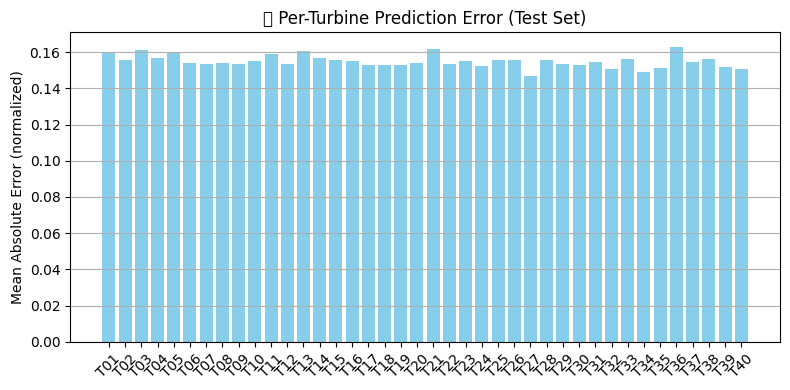

In [30]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# 1. Create error buckets per turbine index
errors_per_turbine = defaultdict(list)

# 2. Collect errors by turbine position
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = model(batch)
        predictions = output.squeeze().cpu().numpy()
        targets = batch.y.cpu().numpy()

        for i in range(len(predictions)):
            turbine_idx = i % len(predictions)  # assumes fixed order
            error = abs(predictions[i] - targets[i])
            errors_per_turbine[turbine_idx].append(error)

# 3. Compute MAE per turbine
turbine_mae = {t: np.mean(errs) for t, errs in errors_per_turbine.items()}

# 4. Sort and plot
sorted_ids = sorted(turbine_mae.keys())
mae_values = [turbine_mae[t] for t in sorted_ids]

plt.figure(figsize=(8, 4))
plt.bar([f"T{t+1:02d}" for t in sorted_ids], mae_values, color='skyblue')
plt.ylabel("Mean Absolute Error (normalized)")
plt.title("📉 Per-Turbine Prediction Error (Test Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


# Select the first StampTime

In [95]:
filtered_df = df[df['StampTime']==df['StampTime'].unique()[0]]

In [96]:
# df.head()

## Extract relevant columns

In [97]:
filtered_df = filtered_df[['Turbine', 'u_vector_cubic', 'v_vector_cubic', 'PowerkW', 'latitude', 'longitude','WindDirection']]

In [98]:
df['StampTime'].unique()[:10]

<DatetimeArray>
['2022-03-01 00:00:00', '2022-03-01 00:10:00', '2022-03-01 00:20:00',
 '2022-03-01 00:30:00', '2022-03-01 00:40:00', '2022-03-01 00:50:00',
 '2022-03-01 01:00:00', '2022-03-01 01:10:00', '2022-03-01 01:20:00',
 '2022-03-01 01:30:00']
Length: 10, dtype: datetime64[ns]

## Standardize wind vectors

In [99]:
scaler_vectors = StandardScaler()
filtered_df[['u_vector_cubic', 'v_vector_cubic']] = scaler_vectors.fit_transform(
    filtered_df[['u_vector_cubic', 'v_vector_cubic']]
)

## Standardize latitude and longitude

In [100]:
scaler_positions = StandardScaler()
filtered_df[['latitude', 'longitude']] = scaler_positions.fit_transform(
    filtered_df[['latitude', 'longitude']]
)

In [101]:
turbine_positions = {
    row['Turbine']: (row['latitude'], row['longitude'])
    for _, row in filtered_df.iterrows()
}

In [102]:
# turbine_positions

## Normalize PowerkW to range [0, 1]

In [103]:
scaler_power = MinMaxScaler()
filtered_df['PowerkW'] = scaler_power.fit_transform(filtered_df[['PowerkW']])


## Prepare wind data dictionary

In [104]:
wind_data = {
    row['Turbine']: [
        row['u_vector_cubic'], 
        row['v_vector_cubic'], 
        row['PowerkW'], 
        row['latitude'], 
        row['longitude']
    ] 
    for _, row in filtered_df.iterrows()
}


In [105]:
filtered_df

,Turbine,u_vector_cubic,v_vector_cubic,PowerkW,latitude,longitude,WindDirection
0,T01,-0.218492,-0.113959,0.598784,1.504645,-0.091851,219.0
1,T02,0.965046,-0.794868,0.887538,0.186142,-1.182581,151.0
2,T03,-1.847840,1.868352,1.000000,-1.442598,-0.780733,276.0
3,T04,0.547399,-0.030255,0.550152,0.418819,1.687761,166.0
4,T05,0.553886,-0.929270,0.000000,-0.667007,0.367404,171.0


In [106]:
df.iloc[:10,:5]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW
0,T01,2022-03-01 00:00:00,4.5,219.0,187.0
1,T02,2022-03-01 00:00:00,4.9,151.0,282.0
2,T03,2022-03-01 00:00:00,6.0,276.0,319.0
3,T04,2022-03-01 00:00:00,4.1,166.0,171.0
4,T05,2022-03-01 00:00:00,4.8,171.0,-10.0
5,T01,2022-03-01 00:10:00,4.2,216.0,149.0
6,T02,2022-03-01 00:10:00,5.2,154.0,332.0
7,T03,2022-03-01 00:10:00,5.8,278.0,284.0
8,T04,2022-03-01 00:10:00,4.0,162.0,163.0
9,T05,2022-03-01 00:10:00,5.0,166.0,-10.0


In [111]:
filtered_df

,Turbine,u_vector_cubic,v_vector_cubic,PowerkW,latitude,longitude,WindDirection
0,T01,-0.218492,-0.113959,0.598784,1.504645,-0.091851,219.0
1,T02,0.965046,-0.794868,0.887538,0.186142,-1.182581,151.0
2,T03,-1.847840,1.868352,1.000000,-1.442598,-0.780733,276.0
3,T04,0.547399,-0.030255,0.550152,0.418819,1.687761,166.0
4,T05,0.553886,-0.929270,0.000000,-0.667007,0.367404,171.0


In [107]:
graph_data, turbine_ids = create_directional_graph(filtered_df)

In [108]:
print_graph_edges(graph_data, turbine_ids)



Graph Edges (Directed):
T03 → T04
T03 → T05
T04 → T01
T05 → T01


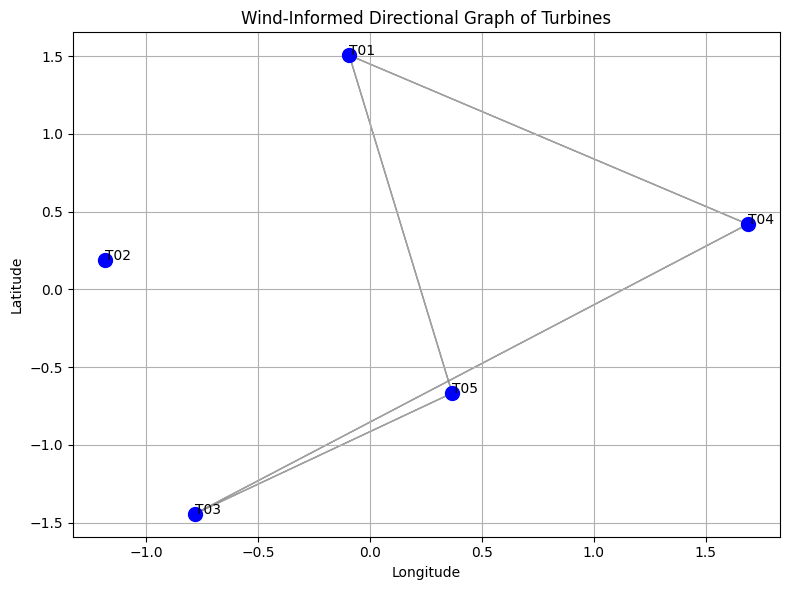

In [109]:
plot_graph_with_arrows(filtered_df, graph_data, turbine_ids)


In [58]:
# Compare azimuth from vectors vs. raw WindDirection
filtered_df['azimuth_from_uv'] = compute_wind_direction(
    filtered_df['u_vector_cubic'], filtered_df['v_vector_cubic']
)

print(filtered_df[['Turbine', 'azimuth_from_uv']])


  Turbine  azimuth_from_uv
0     T01       242.454830
1     T02       129.476858
2     T03       315.316253
3     T04        93.163508
4     T05       149.203199


In [59]:
filtered_df

,Turbine,u_vector_cubic,v_vector_cubic,PowerkW,latitude,longitude,azimuth_from_uv
0,T01,-0.218492,-0.113959,0.598784,1.504645,-0.091851,242.454830
1,T02,0.965046,-0.794868,0.887538,0.186142,-1.182581,129.476858
2,T03,-1.847840,1.868352,1.000000,-1.442598,-0.780733,315.316253
3,T04,0.547399,-0.030255,0.550152,0.418819,1.687761,93.163508
4,T05,0.553886,-0.929270,0.000000,-0.667007,0.367404,149.203199


In [41]:
df.iloc[:5,:6]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,u_vector
0,T01,2022-03-01,4.5,219.0,187.0,-2.831942
1,T02,2022-03-01,4.9,151.0,282.0,2.375567
2,T03,2022-03-01,6.0,276.0,319.0,-5.967131
3,T04,2022-03-01,4.1,166.0,171.0,0.991880
4,T05,2022-03-01,4.8,171.0,-10.0,0.750885


# Create graph data

# Define model